## Notebook Purpose

Evaluate output of "old" fastmri (old codebase w pytorch=1.5 minimally modified to run on pt1.7) vs "new" fastmri (new codebase w pytorch=1.7 built for qdess). Ideally both outputs are the same, or new fastmri is better in all cases. Compare old/new results to the "original" fastmri (samples generated in pt1.5, i.e. old codebase without modification).

##### Process
- noticed some artifacts in fastmri output using new codebase
     - e.g. high frequency, vertical lines in x-ray bones (sometimes accurate to gt, sometimes hallucinated)
     - e.g. noise smearing for high-noise inputs such as vid_key=1000007
- when comparing sub-units within old v new codebase, i.e. see `~/cd_old_branch/conv_decoder_mri/old/DEPREC20201111_fastmri_rework_old_to_new.ipynb`...
    - scaling factor: difference in scaling by ~488 b/w original/new 
        - cause: in pt1.7 fftn(), must set norm='ortho' to match the normalized=True arg of pt1.5 fft()
        - this did account for difference in scaling factor, but didn't solve the artifacts
        - found that norm='ortho' performs slightly better than norm=None in pt1.7
            - TODO: this might not be true for qdess! check this
    - forwardm v forwardm_ (where `_` denotes pt1.7 function)
        - confirmed that the different fft's give the same output
        - investigated difference between chunking vs alternating real/adjacent channels i.e. [15,x,y] <--> [30,x,y]
            - confirmed no difference in performance
        - TBD whether fixing this results in forwardm == forwardm_
            - TODO: are there any external factors which would make this different? How could I test it in this ipynb?
         
##### Findings
- ran old and new over a range of scaling factors `[0.01, 0.05, 0.1, 0.5, 1]`, i.e. a multiplier in front of kspace before scaling
    - changing the scaling factor (sf) does change image quality and presence of artifacts
        - true w both new and old codebase. 
        - codebases have same variance in psnr/ssim across range of scaling factors
        - both codebases deliver the best performance with sf=0.1 or sf=0.05
            - note: individual samples may perform best at a different sf, but each sample has best or worst sf at the end of these ranges, i.e. sf=1 or sf=0.01
    - old v. new codebase
        - perform roughly the same on ssim/psnr at best sf's, i.e. sf=0.1 or sf=0.05
        - both do "smearing" in the presence of noise, e.g. on vid_key=1000007
            - can't reproduce the results i originally had with either old or new codebase. not going to get that back unless i start w heckel's original code
- qualitatively, i'm not excited about the recons w either new or old compared to the original sample
    - currently the "old" codebase is same as the original with minimal modification to run w pytorch==1.7, e.g. fft2()


### TODO: might be able to get original quality back running old codebase w/o modification in an env w pytorch==1.5

### MEANWHILE: run experiments with new codebase, since it performs similarly to the (modified) old codebase

- which scaling factors perform well on different characteristics of images?

In [1]:
import os, sys
from os import listdir
from os.path import isfile, join
import numpy as np
import torch
from matplotlib import pyplot as plt

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, normalize_img

In [2]:
def plot_list(arr_list, title_list=None):
    
    NUM_COLS = len(arr_list)
#     if not title_list:
#         title_list = ['ground-truth', 'old', 'new', 'x']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')
    plt.show()
    
def get_files(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

path_o = '/bmrNAS/people/dvv/out_fastmri/old_pytorch1.5/orig_alpha_search/'
files_o = [f for f in get_files(path_o) if 'iter10000_alpha0.npy' in f]

### best/worst sf's for each sample

##### with new processing

best ssim, psnr over eight samples is roughly equivalent sf=0.1, sf=0.05

In [37]:
sf_dict_best, sf_dict_worst

({'1000007': '0.05',
  '1000273': '0.5',
  '1000325': '0.1',
  '1000464': '1',
  '1000537': '0.5',
  '1000818': '0.1',
  '1001140': '0.1',
  '1001219': '1'},
 {'1000007': '1',
  '1000273': '1',
  '1000325': '1',
  '1000464': '0.01',
  '1000537': '0.01',
  '1000818': '1',
  '1001140': '1',
  '1001219': '0.01'})

In [38]:
print(ssim_avg.mean(), psnr_avg.mean())
print(ssim_var.mean(), psnr_var.mean())

0.7093008650540867 30.148636224183576
0.002104727337045701 2.2379489545794238


##### with old processing

best ssim, psnr over six samples is roughly equivalent sf=0.1, sf=0.05

In [40]:
sf_dict_best, sf_dict_worst

({'1000007': '0.05',
  '1000273': '0.1',
  '1000325': '0.1',
  '1000464': '0.5',
  '1000537': '0.5',
  '1000818': '0.1'},
 {'1000007': '1',
  '1000273': '1',
  '1000325': '0.5',
  '1000464': '0.01',
  '1000537': '0.01',
  '1000818': '1'})

In [41]:
print(ssim_avg.mean(), psnr_avg.mean())
print(ssim_var.mean(), psnr_var.mean())

0.6817281768650836 29.410145711827965
0.00282972187044167 2.9844973063450944


### eval over many sf's

1000007, old: ssim 0.405, psnr 23.931
1000007, 0.1: ssim 0.287, psnr 21.393
1000007
old__: ssim 0.405, psnr 24.0
best_: ssim 0.287, psnr 21.393
worst: ssim 0.287, psnr 21.393


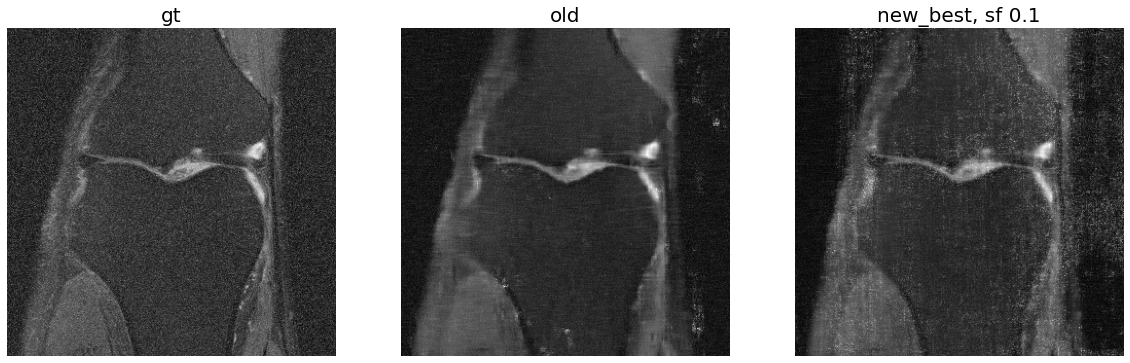

1000273, old: ssim 0.752, psnr 30.837
1000273, 0.1: ssim 0.751, psnr 30.567
1000273
old__: ssim 0.752, psnr 31.0
best_: ssim 0.751, psnr 30.567
worst: ssim 0.751, psnr 30.567


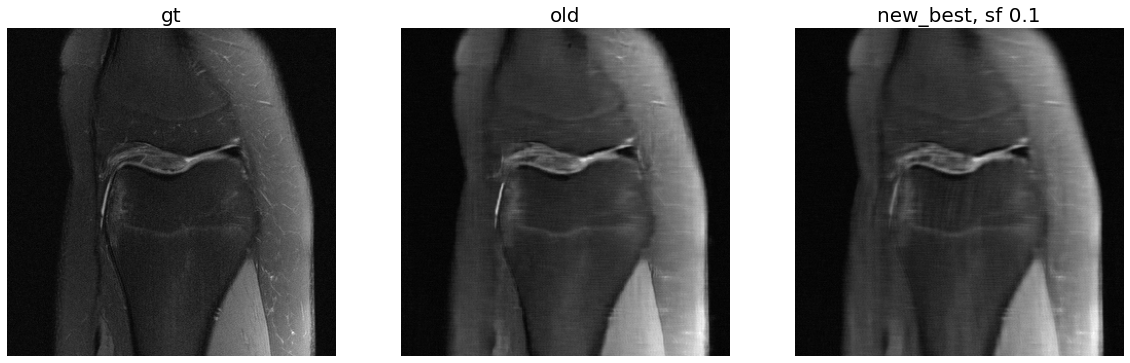

1000325, old: ssim 0.764, psnr 32.143
1000325, 0.1: ssim 0.786, psnr 32.99
1000325
old__: ssim 0.764, psnr 32.0
best_: ssim 0.786, psnr 32.99
worst: ssim 0.786, psnr 32.99


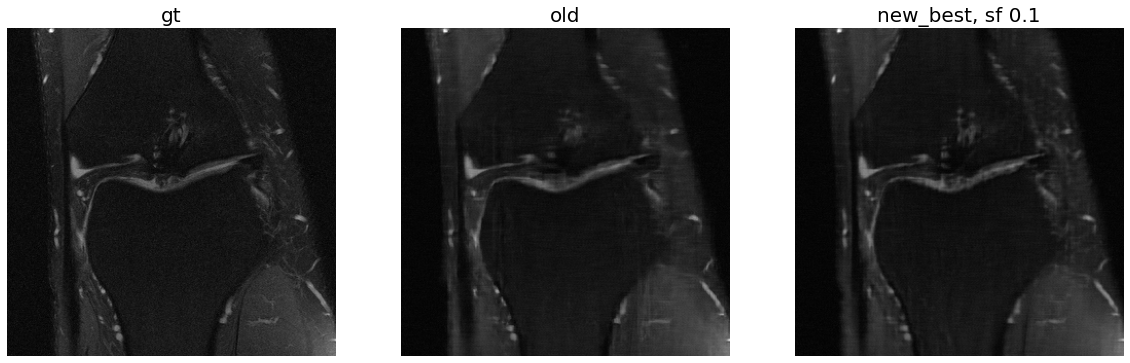

1000464, old: ssim 0.842, psnr 32.622
1000464, 0.1: ssim 0.837, psnr 32.215
1000464
old__: ssim 0.842, psnr 33.0
best_: ssim 0.837, psnr 32.215
worst: ssim 0.837, psnr 32.215


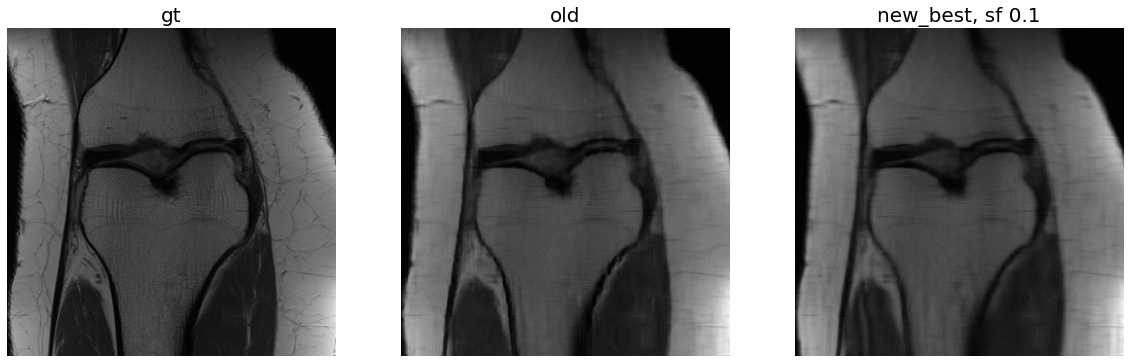

1000537, old: ssim 0.797, psnr 30.982
1000537, 0.1: ssim 0.811, psnr 31.683
1000537
old__: ssim 0.797, psnr 31.0
best_: ssim 0.811, psnr 31.683
worst: ssim 0.811, psnr 31.683


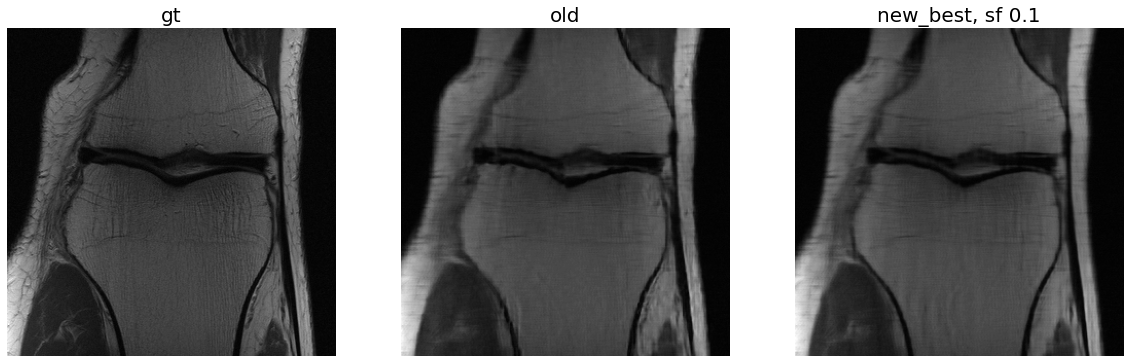

1000818, old: ssim 0.788, psnr 32.07
1000818, 0.1: ssim 0.798, psnr 32.718
1000818
old__: ssim 0.788, psnr 32.0
best_: ssim 0.798, psnr 32.718
worst: ssim 0.798, psnr 32.718


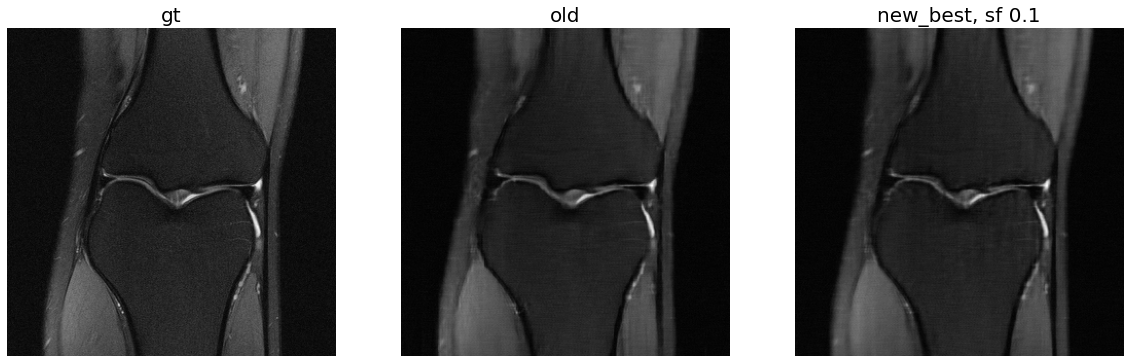

In [47]:
# CHOOSE BETWEEN OLD/NEW CODEBASE
# path_sfs = '/bmrNAS/people/dvv/out_fastmri/new_pytorch1.7/'
# path_sfs = '/bmrNAS/people/dvv/out_fastmri/old_pytorch1.5/'

sf_list = ['1', '0.5', '0.1', '0.05', '0.01']
title_list = ['old'] + sf_list

NUM_VARS = len(sf_list) + 1 # all sf variants plus pt==1.5 version
DIM = 320 # size of square img
arr_list = np.empty((NUM_VARS, DIM, DIM))

# get number of dc samples generated for each sf
files_sf = [f for f in get_files(path_sfs + 'sf1/') if '_dc.npy' in f]
NUM_SAMPS = len(files_sf)

sf_dict_best, sf_dict_worst = {}, {}
ssim_avg, psnr_avg = [], [] # each entry is average across sf's for an individual sample
ssim_var, psnr_var = [], [] # each entry is variance across sf's for an individual sample

for f in files_sf[:NUM_SAMPS]:
    
    ssim_list, psnr_list = [], []
    
    vid_key = f.split('_')[0]
    
    arr_gt = np.load('{}sf1/{}_gt.npy'.format(path_sfs, vid_key))#[None,:]
    arr_o = np.load('{}{}_iter10000_alpha0.npy'.format(path_o, vid_key))#[None,:]
    arr_list[0] = arr_o
        
    for idx_sf, sf in enumerate(sf_list):
        arr_sf = np.load('{}sf{}/{}_dc.npy'.format(path_sfs, sf, vid_key))#[None,:]
        arr_list[idx_sf+1] = arr_sf # offset of 1 b/c old pt==1.5 version already in place
        
    # calc metrics
    for idx, arr in enumerate(arr_list):
        _, _, ssim_, psnr_ = calc_metrics(arr, arr_gt)#[0])
        print('{}, {}: ssim {}, psnr {}'.format(vid_key, title_list[idx], \
                                np.round(ssim_, 3), np.round(psnr_, 3)))
        ssim_list.append(ssim_), psnr_list.append(psnr_)
    ssim_list, psnr_list = np.array(ssim_list), np.array(psnr_list)
    
    # store avg, var across all sf's for a given sample
    SKIP = 1 # if 1 i.e. true, don't include the "old" sample
    ssim_avg.append(ssim_list[SKIP:].mean()), psnr_avg.append(psnr_list[SKIP:].mean())
    ssim_var.append(ssim_list[SKIP:].var()), psnr_var.append(psnr_list[SKIP:].var())
        
    # get best/worst recon of sfs, i.e. must remove old but maintain idx integrity
    idx_max_ssim, idx_max_psnr = np.argmax(ssim_list[1:]) + 1, np.argmax(psnr_list[1:]) + 1
    idx_min_ssim, idx_min_psnr = np.argmin(ssim_list[1:]) + 1, np.argmin(psnr_list[1:]) + 1
    if idx_max_ssim != idx_max_psnr:
        print('max ssim at idx {}, max psnr at idx {}'.format(idx_max_ssim, idx_max_psnr))
    arr_sf_best, arr_sf_worst = arr_list[idx_max_ssim], arr_list[idx_min_ssim]

    max_ssim, max_psnr = np.round(ssim_list[idx_max_ssim],3), np.round(psnr_list[idx_max_psnr],3)
    min_ssim, min_psnr = np.round(ssim_list[idx_min_ssim],3), np.round(psnr_list[idx_min_psnr],3)
    
    print(vid_key)
    print('old__: ssim {}, psnr {}'.format(np.round(ssim_list[0],3), np.round(psnr_list[0]),3))
    print('best_: ssim {}, psnr {}'.format(max_ssim, max_psnr))
    print('worst: ssim {}, psnr {}'.format(min_ssim, min_psnr))
    
    sf_dict_best[vid_key], sf_dict_worst[vid_key] = title_list[idx_max_ssim], \
                                                    title_list[idx_min_ssim]
    
    arr_plot_list = np.concatenate((arr_gt[None,:], arr_o[None,:], \
                                    arr_sf_best[None,:], arr_sf_worst[None,:]), axis=0)
    title_plot_list = ['gt', 'old', 'new_best, sf {}'.format(title_list[idx_max_ssim]),
                                    'new_worst, sf {}'.format(title_list[idx_min_ssim])]
    plot_list(arr_plot_list, title_plot_list)
    
ssim_avg, psnr_avg, ssim_var, psnr_var = np.array(ssim_avg), np.array(psnr_avg), \
                                         np.array(ssim_var), np.array(psnr_var)